In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = 'SimHei' # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False
df_train = pd.read_excel('train_data.xlsx', index_col=0, parse_dates=['TradingDate'])
df_validation = pd.read_excel('validation_data.xlsx', index_col=0, parse_dates=['TradingDate'])
df_test = pd.read_excel('test_data.xlsx', index_col=0, parse_dates=['TradingDate'])
df_train

,Symbol,ShortName,ClosePrice,B
TradingDate,,,,
2013-01-04,1,平安银行,15.99,1.446375
2013-01-07,1,平安银行,16.30,1.867949
2013-01-08,1,平安银行,16.00,0.748016
2013-01-09,1,平安银行,15.86,-0.498651
2013-01-10,1,平安银行,15.87,0.782585
...,...,...,...,...
2020-12-25,1,平安银行,18.04,0.441577
2020-12-28,1,平安银行,18.85,1.826713
2020-12-29,1,平安银行,19.17,1.827038


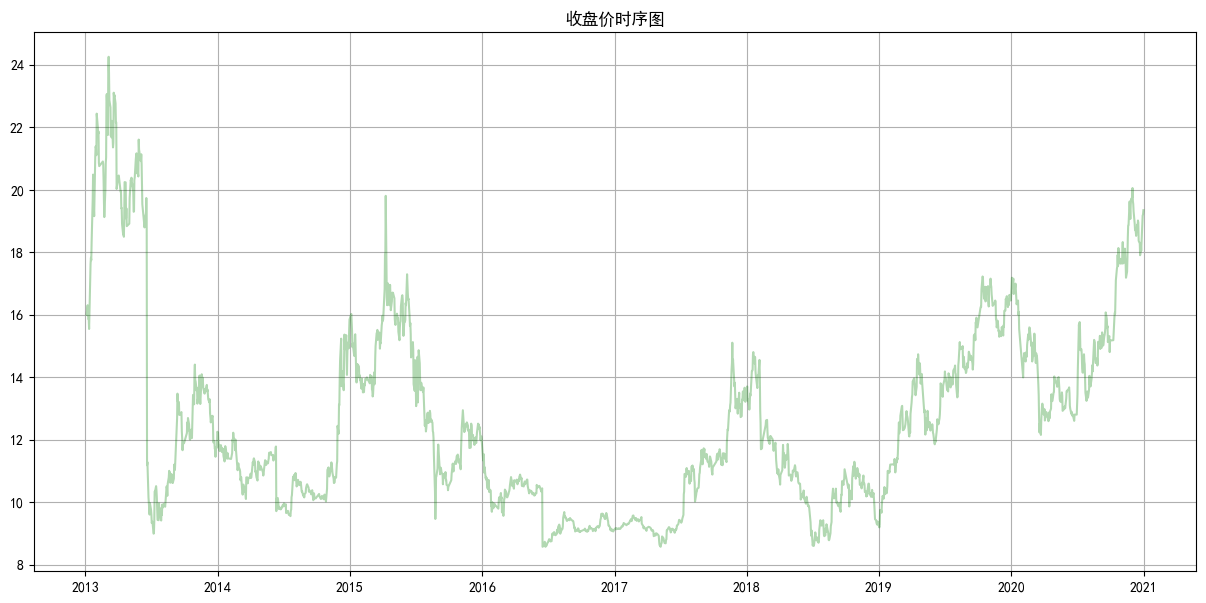

In [2]:
plt.figure(figsize=(15, 7))
plt.plot(df_train['ClosePrice'], color='g',  alpha=0.3)
plt.title('收盘价时序图')
plt.grid(True)
plt.show()

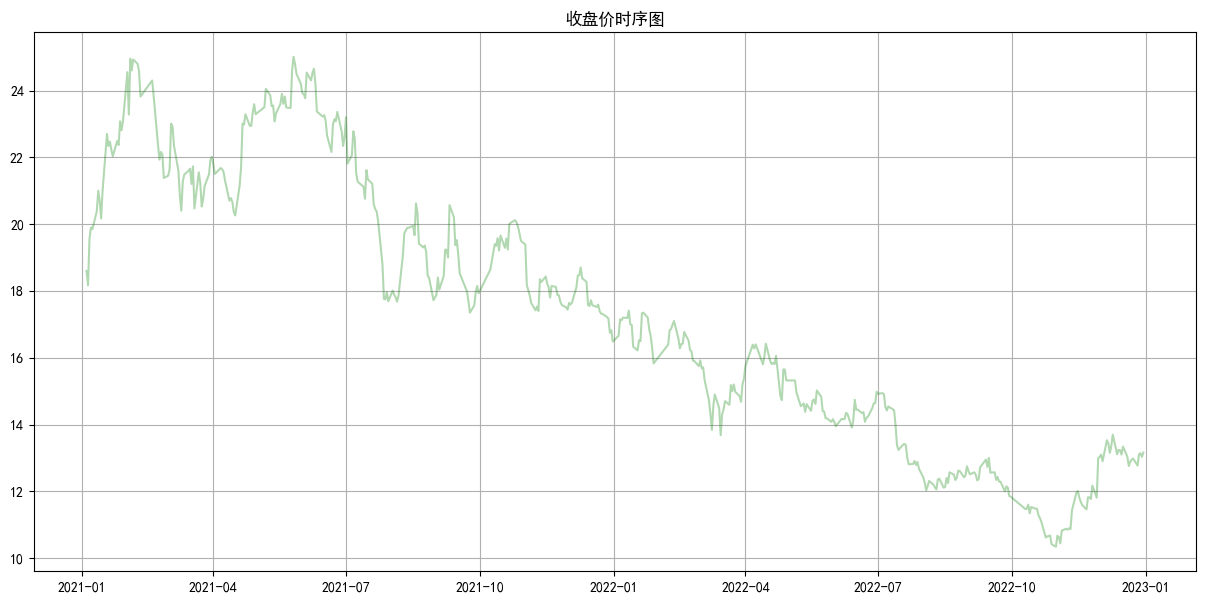

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(df_validation['ClosePrice'], color='g',  alpha=0.3)
plt.title('收盘价时序图')
plt.grid(True)
plt.show()

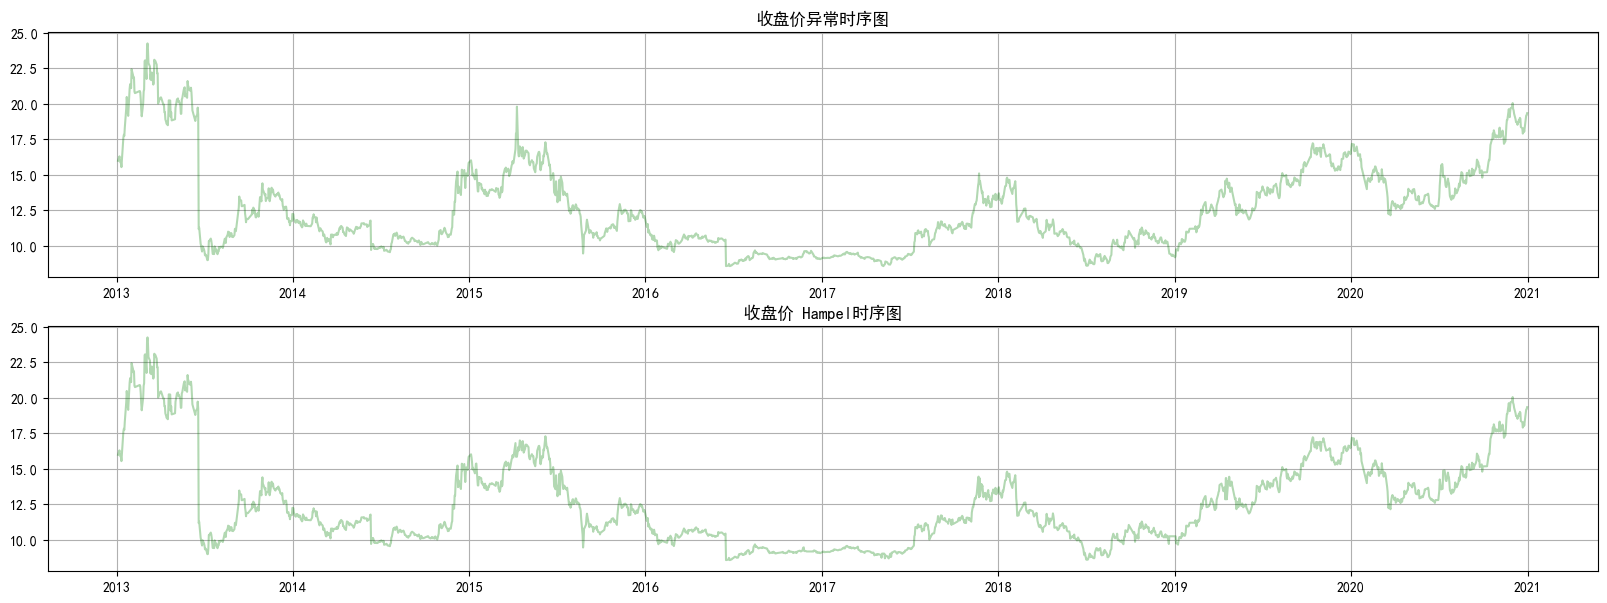

In [4]:
def hampel(vals_orig, k=25, t0=3):
    vals_filt = np.copy(vals_orig)
    outliers_indices = []    
    n = len(vals_orig)
    for i in range(k, n - k):        
        window = vals_orig[i - k:i + k + 1]        
        median = np.median(window)        
        mad = np.median(np.abs(window - median))        
        if np.abs(vals_orig[i] - median) > t0 * mad:            
            vals_filt[i] = median            
            outliers_indices.append(i)
    return vals_filt, outliers_indices
filtered_data, outliers_indices = hampel(df_train['ClosePrice'])
go_over = df_train['ClosePrice']
df_train['ClosePrice'] = filtered_data
plt.figure(figsize=(20, 7))
plt.subplot(2, 1, 1)
plt.plot(go_over, color='g',  alpha=0.3)
plt.title('收盘价异常时序图')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(df_train['ClosePrice'], color='g',  alpha=0.3)
plt.title('收盘价 Hampel时序图')
plt.grid(True)
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
def normalize_dataframe(train_df, validation_df):    
    scaler = MinMaxScaler()    
    scaler.fit(train_df)  # 在训练集上拟合归一化模型   
    train_data = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index = df_train.index)    
    validation_data = pd.DataFrame(scaler.transform(validation_df), columns=validation_df.columns, index = df_validation.index)    
    return train_data, validation_data,scaler
# 调用函数，并接收 scaler
data_train, data_validation, scaler = normalize_dataframe(
    df_train.loc[:, ['ClosePrice']], 
    df_validation.loc[:, ['ClosePrice']]
)

In [6]:
def prepare_data(data,win_size,target_feature_idx):
    num_features = data.shape[1]    
    X = []      
    y = []  
    for i in range(len(data)-win_size):
                temp_x = data[i:i + win_size, :] 
                temp_y = data[i + win_size, target_feature_idx]
                X.append(temp_x)
                y.append(temp_y) 
    X = np.asarray(X) 
    y = np.asarray(y)
    return X, y
win_size = 50 # 时间窗口
target_feature_idx = 0 # 指定待预测特征列
train_x, train_y = prepare_data(data_train.values, win_size, target_feature_idx)
validation_x, validation_y = prepare_data(data_validation.values, win_size, target_feature_idx)
# 归一化测试集（关键！必须在 prepare_data 之前）
data_test = pd.DataFrame(
    scaler.transform(df_test[['ClosePrice']]),
    columns=['ClosePrice'],
    index=df_test.index
)
test_x, test_y = prepare_data(data_test.values, win_size, target_feature_idx)
print("训练集形状:", train_x.shape, train_y.shape)
print("测试集形状:", validation_x.shape, validation_y.shape)
# 此时 df.index 就是纯净的 A 股交易日！
train_start=df_train.index[50].strftime('%Y-%m-%d')
train_end=df_train.index[-1].strftime('%Y-%m-%d')
validation_start=df_validation.index[50].strftime('%Y-%m-%d')
validation_end=df_validation.index[-1].strftime('%Y-%m-%d')
test_start=df_test.index[0].strftime('%Y-%m-%d')
test_end=df_test.index[-1].strftime('%Y-%m-%d')
train_dates = data_train.loc[train_start:train_end].index
validation_dates  = data_validation.loc[validation_start:validation_end].index
test_dates  = data_test.loc[test_start:test_end].index

训练集形状: (1891, 50, 1) (1891,)
测试集形状: (435, 50, 1) (435,)


Epoch 1/30
60/60 [==============================] - 5s 51ms/step - loss: 0.0095 - val_loss: 0.0014
Epoch 2/30
60/60 [==============================] - 3s 45ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/30
60/60 [==============================] - 3s 42ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/30
60/60 [==============================] - 3s 46ms/step - loss: 9.6809e-04 - val_loss: 0.0014
Epoch 5/30
60/60 [==============================] - 3s 44ms/step - loss: 8.6865e-04 - val_loss: 0.0014
Epoch 6/30
60/60 [==============================] - 3s 43ms/step - loss: 8.3266e-04 - val_loss: 0.0011
Epoch 7/30
60/60 [==============================] - 2s 39ms/step - loss: 7.5188e-04 - val_loss: 0.0012
Epoch 8/30
60/60 [==============================] - 2s 40ms/step - loss: 8.2531e-04 - val_loss: 0.0022
Epoch 9/30
60/60 [==============================] - 3s 42ms/step - loss: 7.1171e-04 - val_loss: 7.6544e-04
Epoch 10/30
60/60 [==============================] - 2s 41ms/step - loss: 7.1265e

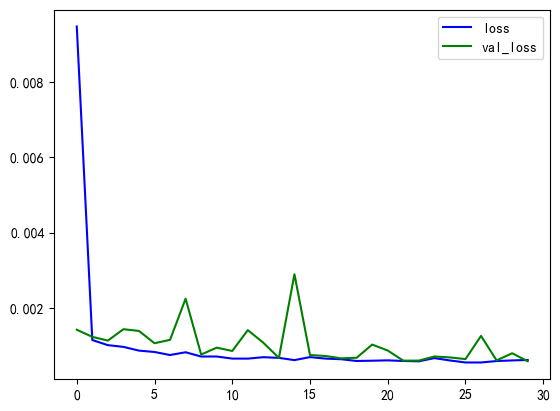

In [ ]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
# 模型构建
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
# 编译模型
model.compile(loss='mse', optimizer = 'adam')
# 模型拟合
history = model.fit(train_x, train_y, epochs=30, batch_size=32, validation_data=(validation_x, validation_y))
plt.figure()
plt.plot(history.history['loss'], c='b', label = 'loss')
plt.plot(history.history['val_loss'], c='g', label = 'val_loss')
plt.legend()
plt.show()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76929 (300.50 KB)
Trainable params: 76929 (300.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from sklearn import metrics
y_pred = model.predict(validation_x)
# 计算均方误差（MSE）
mse = metrics.mean_squared_error(validation_y, np.array([i for arr in y_pred for i in arr]))
# 计算均方根误差（RMSE）
rmse = np.sqrt(mse)
# 计算平均绝对误差（MAE）
mae = metrics.mean_absolute_error(validation_y, np.array([i for arr in y_pred for i in arr]))
from sklearn.metrics import r2_score  #拟合优度
r2 = r2_score(validation_y, np.array([i for arr in y_pred for i in arr]))
print("均方误差 (MSE):", mse)
print("均方根误差 (RMSE):", rmse)
print("平均绝对误差 (MAE):", mae)
print("拟合优度:", r2)

14/14 [==============================] - 1s 10ms/step
均方误差 (MSE): 0.0005871914087820884
均方根误差 (RMSE): 0.024232032700169593
平均绝对误差 (MAE): 0.017063554048664043
拟合优度: 0.989903907701679


60/60 [==============================] - 1s 11ms/step


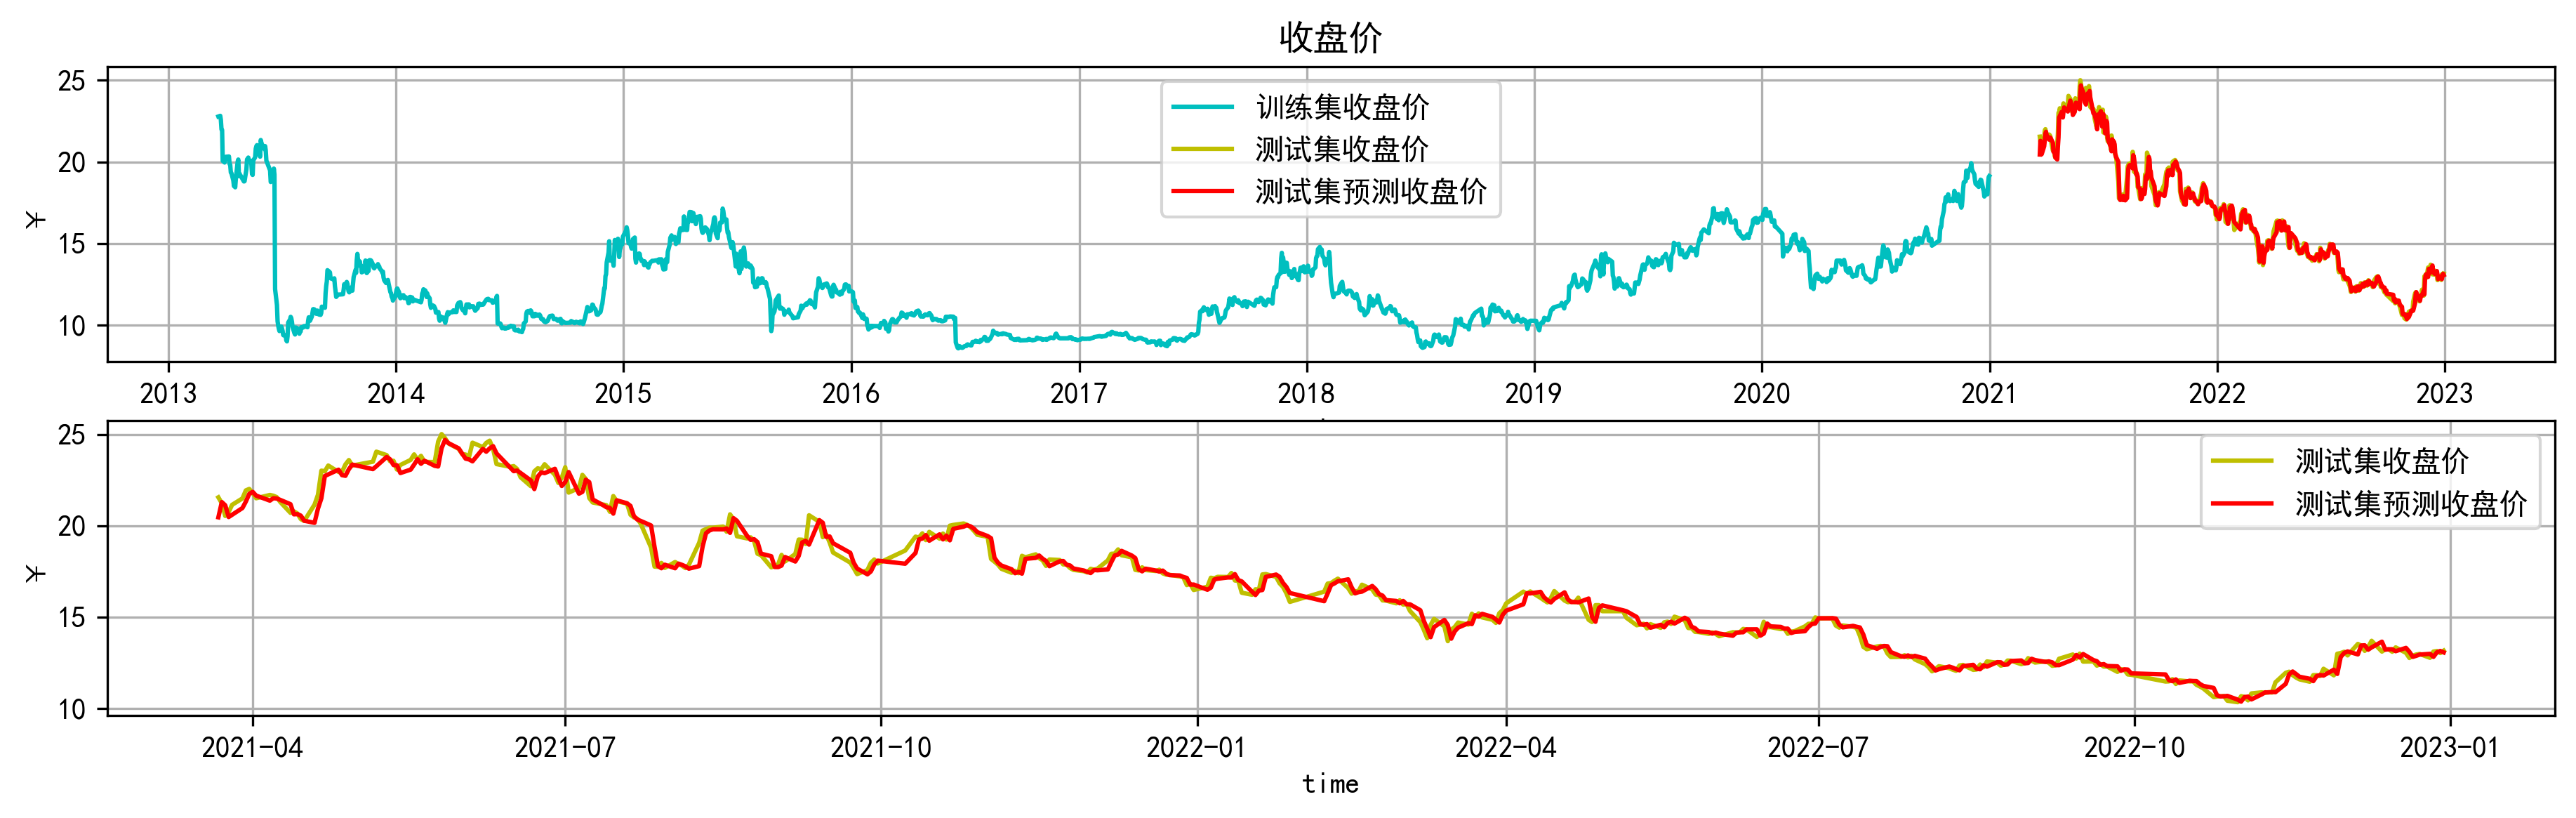

In [10]:
train_max = np.max(df_train['ClosePrice'])
train_min = np.min(df_train['ClosePrice'])

plt.figure(figsize=(15,4), dpi =300)
plt.subplot(2, 1, 1)
plt.plot(train_dates     
         ,model.predict(train_x)*(train_max-train_min)+train_min, color = 'c', label = '训练集收盘价')
plt.plot(validation_dates        
         ,validation_y*(train_max-train_min)+train_min, color = 'y', label = '测试集收盘价')
plt.plot(validation_dates            
         ,y_pred*(train_max-train_min)+train_min, color = 'r', label = '测试集预测收盘价')

plt.title('收盘价')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('￥')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(validation_dates           
         ,validation_y*(train_max-train_min)+train_min, color = 'y', label = '测试集收盘价')
plt.plot(validation_dates    
         ,y_pred*(train_max-train_min)+train_min, color = 'r', label = '测试集预测收盘价')

plt.grid(True)
plt.xlabel('time')
plt.ylabel('￥')
plt.legend()
plt.show()

In [11]:
# 合并训练+验证集作为历史
df_hist = pd.concat([df_train, df_validation]).sort_index()
data_hist = pd.DataFrame(
    scaler.transform(df_hist[['ClosePrice']]),
    columns=['ClosePrice'],
    index=df_hist.index
)

In [12]:

total_steps = len(df_test)
all_predictions = []

# 初始序列：历史最后 win_size 天的 ClosePrice（shape: (win_size, 1)）
current_sequence = data_hist.values[-win_size:].copy()  # (win_size, 1)

for current_start_idx in range(total_steps):
    # 1. 预测下一个 ClosePrice（输入 shape: (1, win_size, 1)）
    pred_norm = model.predict(current_sequence.reshape(1, win_size, 1), verbose=0)[0, 0]
    
    # 2. 反归一化预测值
    pred_actual = scaler.inverse_transform([[pred_norm]])[0, 0]
    all_predictions.append(pred_actual)
    
    # 3. 获取当天真实的 ClosePrice
    real_ClosePrice = df_test['ClosePrice'].iloc[current_start_idx]
    
    # 4. 归一化真实值，并更新序列
    real_step_norm = scaler.transform([[real_ClosePrice]])[0, 0]  # 标量
    
    # 滚动窗口：去掉第一个，加入新的真实值（保持 shape (win_size, 1)）
    current_sequence = np.vstack([current_sequence[1:], [[real_step_norm]]])

# 转为 numpy 数组
all_predictions = np.array(all_predictions)



d:\ANA\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\ANA\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\ANA\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\ANA\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\ANA\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\ANA\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featu

单变量一天一更新预测 MSE: 0.0327
RMSE: 0.1809 | MAE: 0.1260 | R²: 0.9820


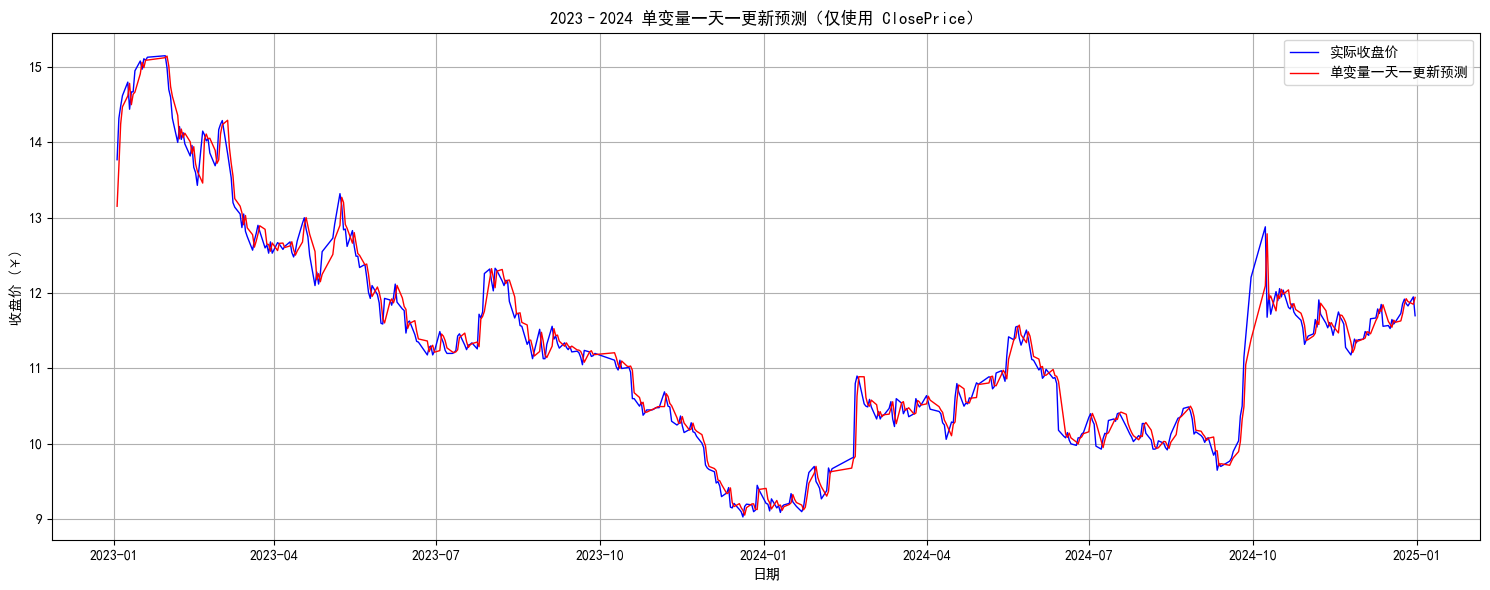

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 评估
actual = df_test['ClosePrice'].values
mse = mean_squared_error(actual, all_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, all_predictions)
r2 = r2_score(actual, all_predictions)

print(f"单变量一天一更新预测 MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

# 绘图
plt.figure(figsize=(15, 6))
plt.plot(df_test.index, actual, label='实际收盘价', color='blue', linewidth=1)
plt.plot(df_test.index, all_predictions, label='单变量一天一更新预测', color='red', linewidth=1)
plt.title('2023–2024 单变量一天一更新预测（仅使用 ClosePrice）')
plt.xlabel('日期')
plt.ylabel('收盘价 (￥)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
actual.shape
all_predictions.shape

(484,)